# Seedtag codetest: NLP Researcher

## Part 1. Classification baseline model

This communication contains a classification baseline model.  However, according to our intelligence department:

- rebels have hacked some texts from one of the categories.

Thus, you should take care of noisy data when improving the baseline model.


In [1]:
import os
import itertools
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
#plot_confusion_matrix

# New imports
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity

import spacy
nlp = spacy.load("en_core_web_md")

from sentence_transformers import SentenceTransformer
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

c:\Users\RodrigoMartínezAlons\OneDrive - Sparrow Networks GmbH\Python\venv_seedtag\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Necessary Installations:

! pip install nltk spacy sentence-transformers scikit-learn imbalanced-learn

!python -m spacy download en_core_web_md

### 0. Auxiliary Functions

In [2]:
def create_df(path, tag):
    '''
    Creates a data frame for a given class
    --------------------------------------
    Input:
        path (str): path where all classes folders are stored.
        tag (str): name of the folder containing class "tag".
    Output:
        df (pd.DataFrame): dataframe with file as index and columns=[text, tag]
    '''
    list_of_text = []
    tag_dir = os.path.join(path, tag)
    for file in os.listdir(tag_dir):

        with open(os.path.join(tag_dir, file), encoding="utf-8", errors="ignore") as f:
            text = f.read()
            list_of_text.append((text, file))
            df = pd.DataFrame(list_of_text, columns = ['Text', 'file'])
            df = df.set_index('file')
    df['tag'] = tag
    return df


def get_all_dfs(path, tags):
    '''
    Loops over all classes in path, each in the corresponding folder
    --------------------------------
    Input:
        path (str): path where all classes folders are stored.
        tags (list): list of classes names.
    Output:
        df (pd.DataFrame): pandas dataframe with the dataframes corresponding to all classes concatenated.
    '''
    list_of_dfs = []
    for tag in tags:

        df = create_df(path, tag)
        list_of_dfs.append(df)
    data = pd.concat(list_of_dfs)
    return data


def tfidf_features(X_train, X_val, X_test, max_features=None):
    """
        X_train, X_val, X_test — samples
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=10,
        max_df=0.1,
        ngram_range=(1,1),
        stop_words='english',
        token_pattern=r'([a-zA-Z0-9-/]{2,})')
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)

    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_


def _score(y_true, y_pred):
    diff = (y_true - y_pred)
    return np.log1p(diff)


def train_clf(X_train, y_train, sol, c, pen):
    """
    X_train, y_train: training data
    c: regularization parameter for LogisticRegression
    pen: penalty for LogisticRegression

    return: trained classifier
    """
    clf = OneVsRestClassifier(
        LogisticRegression(solver=sol, C=c, penalty=pen, class_weight='balanced'),
        n_jobs=-1)
    clf.fit(X_train, y_train)
    return clf

def parameter_search(model, X_train, y_train, X_val, y_val, solver_grid, c_grid, pen_grid, verbose=False):
    '''
    model: pretrained model
    X_train, y_train: training data
    X_val, y_val: validation data
    c_grid: values for regularization c parameter
    pen_grid: values for penalty parameter
    verbose (bool): whether the score values during hyperparameter tunning are displayed.

    return: best parameters, best classifier
    '''
    ac_scores = []
    scores = []
    grid = [(sol, c, pen) for sol in solver_grid for c in c_grid for pen in pen_grid]
    for sol, c, pen in tqdm(grid):

        gen_classifier = model(X_train, y_train, sol, c, pen)
        y_pred = gen_classifier.predict(X_val)
        ac_score, score = accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='weighted')
        if verbose:
            print('For parameters ({}, {:3.2f}, {}), (accuracy, f1_score) are: ({:.6f}, {:.6f})'.format(
                sol, c, pen, ac_score, score))
        ac_scores.append(ac_score)
        scores.append(score)
    best_ind = np.argmax(np.array(scores))
    best_parms = grid[best_ind]
    best_clf = train_clf(X_train, y_train, best_parms[0], best_parms[1], best_parms[2])
    print('Model generated: the best values for the parameters are {}'.format(best_parms))
    return best_clf

def train(dir_name):
    """
    Wrap up function that trains a classification model.
    --------------------------------------------------
    Input:
        dir_name (str): name if the folder containing one subfolder for each class.
    Output:
        model (estimator): LogisticRegression classification model based on OneVsRest approach,
        with a tfidf vector representation for the features.
    """

    tags = os.listdir(path)

    ## data cleaning
    data_full = get_all_dfs(dir_name, tags)
    data_dedup = data_full.drop_duplicates()
    null_texts = data_dedup[data_dedup.Text.duplicated(keep=False)].index
    data = data_dedup.drop(index=null_texts)

    ## text preprocessing
    data_prep = data.copy()

    ## spliting data
    X, X_test, y, y_test = train_test_split(data_prep['Text'], data_prep['tag'], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    ## tfidf_vector representation
    ## features
    X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(
        X_train, X_val, X_test)
    ## labels
    lb = LabelBinarizer()
    y_train_enc = lb.fit_transform(np.transpose([y_train]))
    y_val_enc = lb.transform(y_val)

    ## model training
    SOLVER_GRID = ['liblinear', 'saga']
    C_GRID = [0.01, 0.1, 1, 10, 100, 1000]
    PEN_GRID = ['l1', 'l2']
    print('Training model...')
    model = parameter_search(train_clf, X_train_tfidf, y_train_enc, X_val_tfidf, y_val_enc, SOLVER_GRID, C_GRID, PEN_GRID)
    return model


## Evaluation

def plot_learning_curve(estimator, title, X, y):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features).

    y : array-like, shape (n_samples) or (n_samples, n_features).

    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].set_title(title)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y, cv=5, n_jobs=4, train_sizes=np.linspace(0.1, 1, 6), return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[0].plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

def plot_confusion_matrix(
    cm, classes,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

def evaluate_model(model):
    """
    Generates a set of evaluation tools for the model
    Input:
        model (estimator)
    Output:
        None, prints the score for the test set using accuracy and f1_weighted, it also plots the learning
        curve and the confusion matrix.
    """

    lb = LabelBinarizer()
    y_train_enc = lb.fit_transform(np.transpose([y_train]))
    y_test_enc = lb.transform(y_test)

    y_test_predictions = model.predict(X_test_tfidf)
    y_test_pred = lb.inverse_transform(y_test_predictions)
    ac_score, score = accuracy_score(y_test, y_test_pred), f1_score(y_test, y_test_pred, average='weighted')
    print('(accuracy, f1) are: ({:.6f}, {:.6f})'.format(ac_score, score))

    # learning curve
    plot_learning_curve(model, "Learning Curves (LogReg)", X_train_tfidf, y_train_enc)
    plt.show()

    # testing
    print(classification_report(y_test, y_test_pred))
    # Plot non-normalized confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(12,10))
    plot_confusion_matrix(cnf_matrix, classes=lb.classes_, title="Confusion matrix")
    plt.show()

Extra functions needed

In [3]:
# Cleaning function:

def clean_text(text):

    """
    Standarize all the text, leaving it all in the same format. 
    Eliminating all unnecessary metadata ('Article-I.D.:', '===== ... ====='), special characters, exta whitespaces. 
    Then tokenize, to break down the text into smaller components, and then elimante stopwords and lemmatization to leave ony the meaningful
    Input:
        Text column from the dataframe
    Output:
        Finally, 4 columns are created so we can measure performance differences in all of them: the original, without sw, woth sw and lemmatized and without sw and stemmed.
    """

    text = re.sub(r'Article-I\.D\.:.*\n+', '', text)
    text = re.sub(r'===== .* =====', '', text)
    text = re.sub(r'\[.*?\]', '', text)  
    text = re.sub(r'\*.*?\*', '', text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)     
    text = re.sub(r'\s+', ' ', text.strip()) 
    
    tokens = word_tokenize(text) 
    stop_words = set(stopwords.words('english'))
    tokens_no_stopwords = [word for word in tokens if word not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tokens_no_stopwords]
    
    stemmer = PorterStemmer()
    tokens_stemmed = [stemmer.stem(word) for word in tokens_no_stopwords]
    
    cleaned_text = ' '.join(tokens)
    cleaned_no_stopwords = ' '.join(tokens_no_stopwords)
    cleaned_lemmatized = ' '.join(tokens_lemmatized)
    cleaned_stemmed = ' '.join(tokens_stemmed)
    
    return cleaned_text, cleaned_no_stopwords, cleaned_lemmatized, cleaned_stemmed


def tfidf_params(X_train, X_val, y_train, y_val, param_grid, verbose=False):
    """
    Finds the best hyperparameters for TfidfVectorizer using a Logistic Regression model.
    
    Parameters:
    ----------
    X_train : array-like
        Training data.
    X_val : array-like
        Validation data.
    y_train : array-like
        Training labels.
    y_val : array-like
        Validation labels.
    param_grid : dict
        Dictionary containing TfidfVectorizer parameters to tune.
    verbose : bool, optional (default=False)
        If True, logs progress and parameters during execution.

    Returns:
    -------
    best_vectorizer : TfidfVectorizer
        The best TF-IDF vectorizer fitted on the training data.
    X_train_tfidf : sparse matrix
        TF-IDF transformed training data using the best parameters.
    X_val_tfidf : sparse matrix
        TF-IDF transformed validation data using the best parameters.
    best_params : dict
        The best parameters for TfidfVectorizer.
    """
    best_score = 0
    best_params = None
    best_vectorizer = None

    # Iterate over parameter combinations
    for params in ParameterGrid(param_grid):
        if verbose:
            print(f"Testing parameters: {params}")

        # Initialize the TfidfVectorizer with the current parameter set
        vectorizer = TfidfVectorizer(**params)
        
        # Fit-transform on training data, transform validation data
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_val_tfidf = vectorizer.transform(X_val)
        
        # Train Logistic Regression on TF-IDF features
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train_tfidf, y_train)
        
        # Evaluate using F1-score
        score = f1_score(y_val, clf.predict(X_val_tfidf), average='weighted')
        
        # Update the best parameters, vectorizer, and score if current score is better
        if score > best_score:
            best_score = score
            best_params = params
            best_vectorizer = vectorizer

        if verbose:
            print(f"Score for parameters {params}: {score:.4f}")

    # Fit the best vectorizer again on the training data
    X_train_tfidf = best_vectorizer.fit_transform(X_train)
    X_val_tfidf = best_vectorizer.transform(X_val)

    print("Best TF-IDF params:", best_params)
    print("Best F1-Score:", best_score)

    return best_vectorizer, X_train_tfidf, X_val_tfidf, best_params
    

def train_logistic_regression(X_train_tfidf, y_train, param_grid, verbose=1):
    """
    Train a Logistic Regression model using GridSearchCV with the given TF-IDF parameters.

    Parameters:
    ----------
    X_train_tfidf : sparse matrix
        TF-IDF transformed training data.
    y_train : array-like
        Labels for the training data.
    param_grid : dict
        Parameter grid for Logistic Regression hyperparameter tuning.
    verbose : int, optional (default=1)
        Level of verbosity during GridSearchCV execution.

    Returns:
    --------
    best_model : GridSearchCV
        Fitted GridSearchCV object with the best Logistic Regression model.
    best_params_logreg : dict
        Best parameters for Logistic Regression found during the grid search.
    """
    # Initialize GridSearchCV with Logistic Regression and the given parameter grid
    best_model = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid,
        scoring='f1_weighted',
        cv=5,
        verbose=verbose)

    # Fit the model on the TF-IDF transformed training data
    best_model.fit(X_train_tfidf, y_train)
    best_params_logreg = best_model.best_params_

    # Log the best parameters
    if verbose:
        print("Best Logistic Regression Params:", best_params_logreg)

    return best_model, best_params_logreg


def train_random_forest(X_train, y_train, param_grid, verbose=1):
    """
    Train a Random Forest model using GridSearchCV with the given parameter grid.

    Parameters:
    ----------
    X_train : array-like
        Training data (e.g., embeddings).
    y_train : array-like
        Labels for the training data.
    param_grid : dict
        Parameter grid for Random Forest hyperparameter tuning.
    verbose : int, optional (default=1)
        Level of verbosity during GridSearchCV execution.

    Returns:
    --------
    best_model : GridSearchCV
        Fitted GridSearchCV object with the best Random Forest model.
    best_params_rf : dict
        Best parameters for Random Forest found during the grid search.
    """
    # Initialize GridSearchCV with Random Forest and the given parameter grid
    best_model = GridSearchCV(
        RandomForestClassifier(),
        param_grid,
        scoring='f1_weighted',
        cv=5,
        verbose=verbose
    )

    # Fit the model on the training data
    best_model.fit(X_train, y_train)
    best_params_rf = best_model.best_params_

    # Log the best parameters
    if verbose:
        print("Best Random Forest Params:", best_params_rf)

    return best_model, best_params_rf



def get_spacy_embeddings(texts):
    """
    Generate embeddings using SpaCy.
    
    Args:
        texts (list of str): Input texts to vectorize.
        
    Returns:
        np.ndarray: Document embeddings for all input texts.
    """
    embeddings = []
    for doc in nlp.pipe(texts, disable=["parser", "ner"]):
        embeddings.append(doc.vector)  # Average of word embeddings in the document
    return np.array(embeddings)


def get_transformer_embeddings(model, texts):
    """
    Generate embeddings using a SentenceTransformer model.
    
    Args:
        texts (list of str): Input texts to vectorize.
        
    Returns:
        np.ndarray: Document embeddings for all input texts.
    """
    embeddings = model.encode(texts, show_progress_bar=True)
    return embeddings


def evaluate_model_new(X_train_tfidf, y_train, y_test, y_test_pred, best_model): 
    """
    Evaluates the model's performance using predicted and true labels and generates relevant metrics and visualizations.

    Inputs:
        X_train_tfidf (sparse matrix): TF-IDF representation of the training data.
        y_train (array-like): Training labels for the training data.
        y_test (array-like): True labels for the test data.
        y_test_pred (array-like): Predicted labels for the test data.
        best_model (GridSearchCV): Trained GridSearchCV object containing the best model and parameters.

    Outputs:
        None: Prints accuracy, F1-score, classification report, and plots confusion matrix and learning curves.
    """

    # Calculate and print evaluation metrics
    ac_score = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print(f"(accuracy, f1) are: ({ac_score:.6f}, {f1:.6f})")

    # Print classification report
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

    # Compute and plot confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 7))
    plot_confusion_matrix(cnf_matrix, classes=np.unique(y_test), title="Confusion Matrix")
    plt.show()

    # Plot learning curve using the best model and training data
    plot_learning_curve(best_model.best_estimator_, "Learning Curves (LogReg)", X_train_tfidf, y_train)
    plt.show()


def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

def plot_learning_curve(estimator, title, X, y):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, and the fit times vs score curve.
    """
    from sklearn.model_selection import learning_curve

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].set_title(title)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1, 6), return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[0].plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")


### 1. Loading data

In [4]:
path = '../part1/dataset'
tags = os.listdir(path)
tags

['exploration',
 'headhunters',
 'intelligence',
 'logistics',
 'politics',
 'transportation',
 'weapons']

In [5]:
data_full = get_all_dfs(path, tags)
print(data_full.shape)
data_full.tail()

(3853, 2)


,Text,tag
file,,
55246,\nAs quoted from <1993Apr17.025258.7013@micros...,weapons
55247,\nIn article <2071@rwing.UUCP> pat@rwing.UUCP ...,weapons
55473,07:24:55 GMT\n <1qjmnuINNlmd@cl...,weapons
55474,\nAs quoted from <1993Apr18.000152.2339@gnv.if...,weapons
55475,\nPoliticians want to eliminate private owners...,weapons


In [6]:
data_full.columns

Index(['Text', 'tag'], dtype='object')

In [7]:
data_dedup = data_full.drop_duplicates()
null_texts = data_dedup[data_dedup.Text.duplicated(keep=False)].index
data = data_dedup.drop(index=null_texts)

tag
politics          604
transportation    593
exploration       586
headhunters       583
weapons           546
logistics         469
intelligence      453
Name: count, dtype: int64


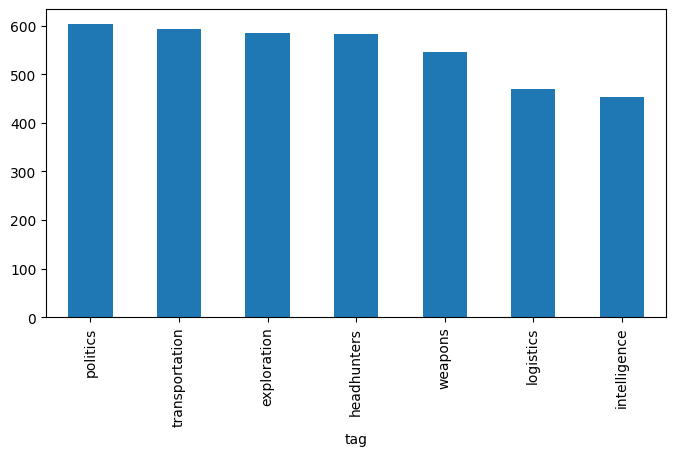

In [8]:
print(data['tag'].value_counts())
plt.figure(figsize=(8,4))
data['tag'].value_counts().plot(kind='bar');

#### 1.2 Extra cleaning process

The texts are quite chaotic and really long. They talk basicly about space exploration, some containing a lot of dense, domain-specific information and some just provide personal comentaries about it. 

They contain many special characters that can be cleaned, like some metadata information (headers, contact details). This function cleans and standarizes the text, but many of them still contain a lot of noise information.

It is important to eliminate stopwords and lemmatize to reduce the length of the tfidf dictionaries and have only the most useful information

In [9]:
data_full['Text'].iloc[2]

'Article-I.D.: cs.astronaut_733694515\n\n\nHOW TO BECOME AN ASTRONAUT\n\n    First the short form, authored by Henry Spencer, then an official NASA\n    announcement.\n\n    Q. How do I become an astronaut?\n\n    A. We will assume you mean a NASA astronaut, since it\'s probably\n    impossible for a non-Russian to get into the cosmonaut corps (paying\n    passengers are not professional cosmonauts), and the other nations have\n    so few astronauts (and fly even fewer) that you\'re better off hoping to\n    win a lottery. Becoming a shuttle pilot requires lots of fast-jet\n    experience, which means a military flying career; forget that unless you\n    want to do it anyway. So you want to become a shuttle "mission\n    specialist".\n\n    If you aren\'t a US citizen, become one; that is a must.  After that,\n    the crucial thing to remember is that the demand for such jobs vastly\n    exceeds the supply.  NASA\'s problem is not finding qualified people,\n    but thinning the lineup 

In [10]:
data_clean=data_full.copy()      # Copy for new columns creation

We leave 4 different combinations, because depending on the model selected some of them can be useful.

In [11]:
data_clean[['cleaned_text', 'no_stopwords', 'lemmatized', 'stemmed']] = data_clean['Text'].apply(lambda x: pd.Series(clean_text(x)))
data_clean.head(2)

,Text,tag,cleaned_text,no_stopwords,lemmatized,stemmed
file,,,,,,
59848,Article-I.D.: cs.controversy_733694426\n\n\nCO...,exploration,controversial questions these issues periodica...,controversial questions issues periodically co...,controversial question issue periodically come...,controversi question issu period come much arg...
59849,Article-I.D.: cs.groups_733694492\n\n\nSPACE A...,exploration,space activistinterestresearch groups and spac...,space activistinterestresearch groups space pu...,space activistinterestresearch group space pub...,space activistinterestresearch group space pub...


All texts are really large and extra cleaning would require more information about specific kind of data that wants to be elimanted.

In [12]:
data_clean['word_count'] = data_clean['lemmatized'].apply(lambda x: len(x.split()))
data_clean['word_count'].describe()

count     3853.000000
mean       171.131326
std        451.933300
min          0.000000
25%         49.000000
50%         88.000000
75%        154.000000
max      15510.000000
Name: word_count, dtype: float64

In [13]:
data_prep=data.copy()

### 2. Features representation

In [14]:
X, X_test, y, y_test = train_test_split(data_prep['Text'], data_prep['tag'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

### 3. Training

In [16]:
classifier_tfidf = train('../part1/dataset')

Training model...


100%|██████████| 24/24 [00:24<00:00,  1.03s/it]


Model generated: the best values for the parameters are ('saga', 1000, 'l2')


Eliminate

In [68]:
# X, X_test, y, y_test = train_test_split(data_prep['Text'], data_prep['tag'], test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# ## tfidf_vector representation
# ## features
# X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(
#     X_train, X_val, X_test)
## labels
lb = LabelBinarizer()
y_train_enc = lb.fit_transform(np.transpose([y_train]))
y_val_enc = lb.transform(y_val)

## model training
SOLVER_GRID = ['liblinear', 'saga']
C_GRID = [0.01, 0.1, 1, 10, 100, 1000]
PEN_GRID = ['l1', 'l2']
print('Training model...')
model = parameter_search(train_clf, X_train_tfidf, y_train_enc, X_val_tfidf, y_val_enc, SOLVER_GRID, C_GRID, PEN_GRID)

Training model...


100%|██████████| 24/24 [00:16<00:00,  1.50it/s]


Model generated: the best values for the parameters are ('saga', 1000, 'l2')


### 4. Evaluation

In [80]:
evaluate_model(classifier_tfidf)

NameError: name 'classifier_tfidf' is not defined

###

#### Conclusions:

Performance is not bad (f1-score=0.88), with the initial approach based on vectorizing with tfidf and classificating with Logistic Regression model.

I will do various iterations with different approaches to try to improve model's performance as much as possible.

### 5. Cleaned data

Let's try and see if performance can be improved just by using the new text we have cleaned

In [19]:
X_clean, X_test_clean, y_clean, y_test_clean = train_test_split(data_clean['lemmatized'], data_clean['tag'], test_size=0.2, random_state=42)
X_train_clean, X_val_clean, y_train_clean, y_val_clean = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

In [82]:
X_train_tfidf_clean, X_val_tfidf_clean, X_test_tfidf_clean, tfidf_vocab_clean,  = tfidf_features(X_train_clean, X_val_clean, X_test_clean)
tfidf_reversed_vocab_clean = {i: word for word, i in tfidf_vocab_clean.items()}

Train and test this model, just using different data but the same approach. Functions cannot be reused, they don't take new data as arguments.

In [83]:
lb_clean = LabelBinarizer()
y_train_enc_clean = lb_clean.fit_transform(y_train_clean)
y_val_enc_clean = lb_clean.transform(y_val_clean)
SOLVER_GRID = ['liblinear', 'saga']
C_GRID = [0.01, 0.1, 1, 10, 100, 1000]
PEN_GRID = ['l1', 'l2']
print('Training model...')
model_clean = parameter_search(train_clf, X_train_tfidf_clean, y_train_enc_clean, X_val_tfidf_clean, y_val_enc_clean, SOLVER_GRID, C_GRID, PEN_GRID)

y_test_enc_clean = lb_clean.transform(y_test_clean)
y_test_predictions = model_clean.predict(X_test_tfidf_clean)
y_test_pred = lb_clean.inverse_transform(y_test_predictions)
test_accuracy = accuracy_score(y_test_clean, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("\nClassification Report:\n")
print(classification_report(y_test_clean, y_test_pred))

Training model...


  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:26<00:00,  1.12s/it]


Model generated: the best values for the parameters are ('saga', 100, 'l1')
Test Accuracy: 0.8793774319066148

Classification Report:

                precision    recall  f1-score   support

   exploration       0.67      0.97      0.79       139
   headhunters       0.93      0.84      0.88       110
  intelligence       0.94      0.81      0.87        98
     logistics       0.98      0.90      0.93        88
      politics       0.96      0.92      0.94       111
transportation       0.94      0.88      0.91       121
       weapons       0.99      0.82      0.89       104

      accuracy                           0.88       771
     macro avg       0.91      0.87      0.89       771
  weighted avg       0.90      0.88      0.88       771



#### Conclusion: 

Using more cleaned data slightly improves the performance, but there is still room for improvement with other approaches

### 6) Tuning TFIDF hyperparameters

Introducing Grid Search for the TFIDF as well and then optimize the hyperparameter seach for the model.

The function parameter_search looks for best hyperparameters manually, instead of that GridSearchCV allows a cleaner and more efficient hyperparameter tuning

In [84]:
# Define the parameter grid
tfidf_grid={'max_features': [5000, 10000, 20000], 'min_df': [5, 10, 20], 'max_df': [0.5, 0.7, 1.0], 'ngram_range': [(1, 1), (1, 2)]}
best_vectorizer, X_train_tfidf, X_val_tfidf, best_params = tfidf_params(X_train_clean, X_val_clean, y_train_clean, y_val_clean, tfidf_grid)

Best TF-IDF params: {'max_df': 0.7, 'max_features': 10000, 'min_df': 5, 'ngram_range': (1, 2)}
Best F1-Score: 0.944421133484216


In [85]:
model_grid = {'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
best_model, best_params_logreg = train_logistic_regression(X_train_tfidf, y_train_clean, model_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}


(accuracy, f1) are: (0.939040, 0.938885)

Classification Report:
                 precision    recall  f1-score   support

   exploration       0.95      0.94      0.95       139
   headhunters       0.88      0.97      0.93       110
  intelligence       0.99      0.85      0.91        98
     logistics       0.92      0.95      0.94        88
      politics       0.93      0.96      0.95       111
transportation       0.95      0.95      0.95       121
       weapons       0.96      0.93      0.95       104

      accuracy                           0.94       771
     macro avg       0.94      0.94      0.94       771
  weighted avg       0.94      0.94      0.94       771



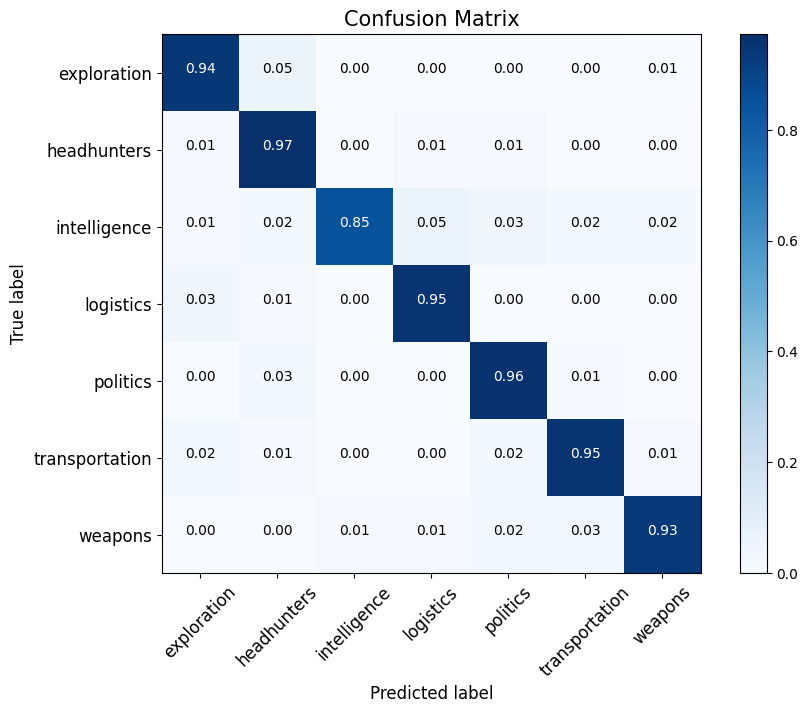

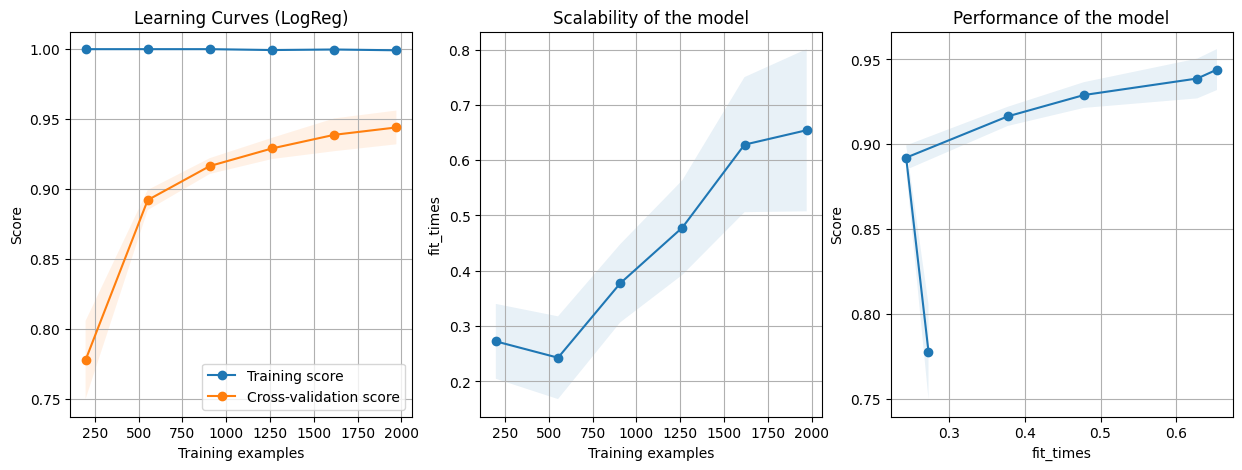

In [86]:
X_test_tfidf = best_vectorizer.transform(X_test_clean)
y_test_pred = best_model.predict(X_test_tfidf)
evaluate_model_new(X_train_tfidf, y_train_clean, y_test_clean, y_test_pred, best_model)

#### Conclusion:

Tuning hyperparameters for TF-IDF and Logistic Regression improves performance by 5%

#### Extra Analysis

Calculate the maximum probability the model is assigning to every category helps to evaluate how sure the model is of the decisions it is taking.

In [94]:
X_test_tfidf = best_vectorizer.transform(X_test_clean)
y_test_proba = best_model.predict_proba(X_test_tfidf)
y_test_pred = best_model.predict(X_test_tfidf)
max_probabilities_test = y_test_proba.max(axis=1)

test_results = pd.DataFrame({
    'Text': X_test_clean,  # Assuming X_test_clean is the raw text; modify if preprocessed
    'Predicted_Category': y_test_pred,
    'Max_Probability': max_probabilities_test,
    'Real_Values': y_test_clean})

test_results.head()

,Text,Predicted_Category,Max_Probability,Real_Values
file,,,,
103193,article 1qvrnpinnnidshelleyuwashingtonedu yong...,transportation,0.972057,transportation
61118,article 1993apr230000211auroraalaskaedu nsmcaa...,exploration,0.827371,exploration
60952,one time speculation first spacewalk alexei le...,exploration,0.588115,exploration
54660,thomas parsli thomaspifiuiono writes dont reme...,weapons,0.946308,weapons
51178,zaphodmpsohiostateeduwupostuunetoliveasgigateo...,logistics,0.907351,logistics


In [96]:
test_results.Max_Probability.describe()

count    771.000000
mean       0.783583
std        0.182214
min        0.196083
25%        0.728097
50%        0.857183
75%        0.908985
max        0.990725
Name: Max_Probability, dtype: float64

In [100]:
# Probabilities by category
mean_probabilities = test_results.groupby('Predicted_Category')['Max_Probability'].mean().reset_index()
print(mean_probabilities)

  Predicted_Category  Max_Probability
0        exploration         0.805505
1        headhunters         0.732573
2       intelligence         0.762917
3          logistics         0.787469
4           politics         0.814834
5     transportation         0.787052
6            weapons         0.791444


Flagging cases for manual review where the probability falls below a threshold set by stakeholders can be an effective strategy to manage uncertain classifications. Additionally, these cases could be assigned to a new category labeled "Undefined" to indicate the need for further evaluation. 

We can also plot the most important terms for each category and review them with stakeholders to see if they match their expectations.

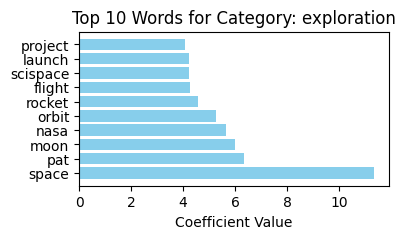

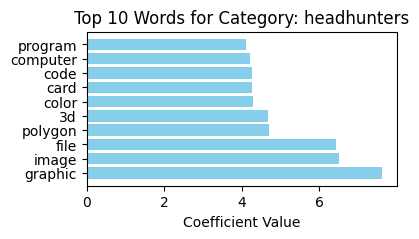

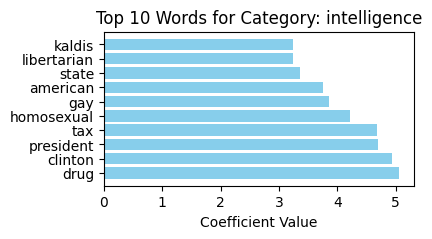

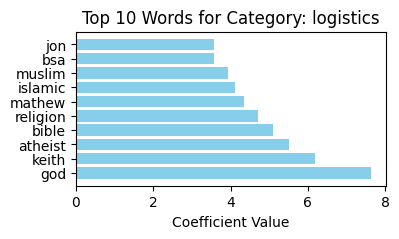

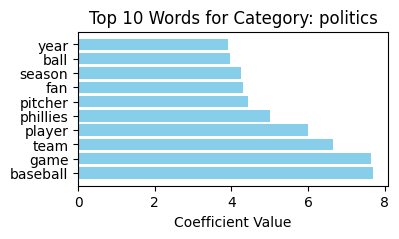

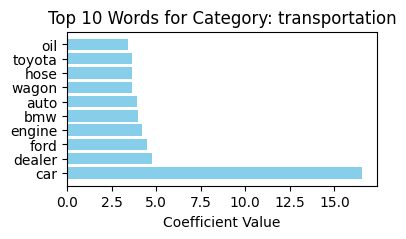

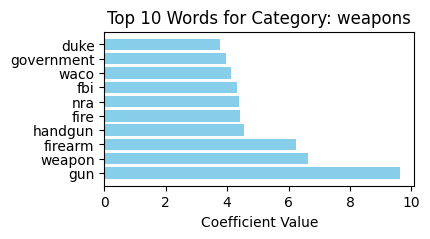

In [102]:
vectorizer = best_vectorizer
log_reg = best_model.best_estimator_

feature_names = np.array(vectorizer.get_feature_names_out())
coefficients = log_reg.coef_

# Top 10 words
for i, category in enumerate(log_reg.classes_):
    sorted_indices = coefficients[i].argsort() 
    top_words = feature_names[sorted_indices[-10:]]
    top_coeffs = coefficients[i][sorted_indices[-10:]]
    
    # Plotting
    plt.figure(figsize=(4, 2))
    plt.barh(top_words, top_coeffs, color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 10 Words for Category: {category}')
    plt.gca().invert_yaxis() 
    plt.show()


### 7) Using Embeddings for vectorization 

This vectorization captures the semantic relationships between words and they consider the context in which a word appears. They can be more efficient in more complex tasks but it depends on the kind of data we are dealing with.

#### 7.1) Using Spacy models

In [27]:
# Generate embeddings
X_train_spacy = get_spacy_embeddings(X_train_clean)
X_val_spacy = get_spacy_embeddings(X_val_clean)
X_test_spacy = get_spacy_embeddings(X_test_clean)

In [ ]:
model_grid_spacy = {'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
best_model_spacy, best_params_logreg_spacy = train_logistic_regression(X_train_spacy, y_train_clean, model_grid_spacy)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


(accuracy, f1) are: (0.821012, 0.820573)

Classification Report:
                 precision    recall  f1-score   support

   exploration       0.79      0.87      0.83       139
   headhunters       0.88      0.82      0.85       110
  intelligence       0.81      0.70      0.75        98
     logistics       0.81      0.88      0.84        88
      politics       0.89      0.86      0.88       111
transportation       0.80      0.82      0.81       121
       weapons       0.78      0.78      0.78       104

      accuracy                           0.82       771
     macro avg       0.82      0.82      0.82       771
  weighted avg       0.82      0.82      0.82       771



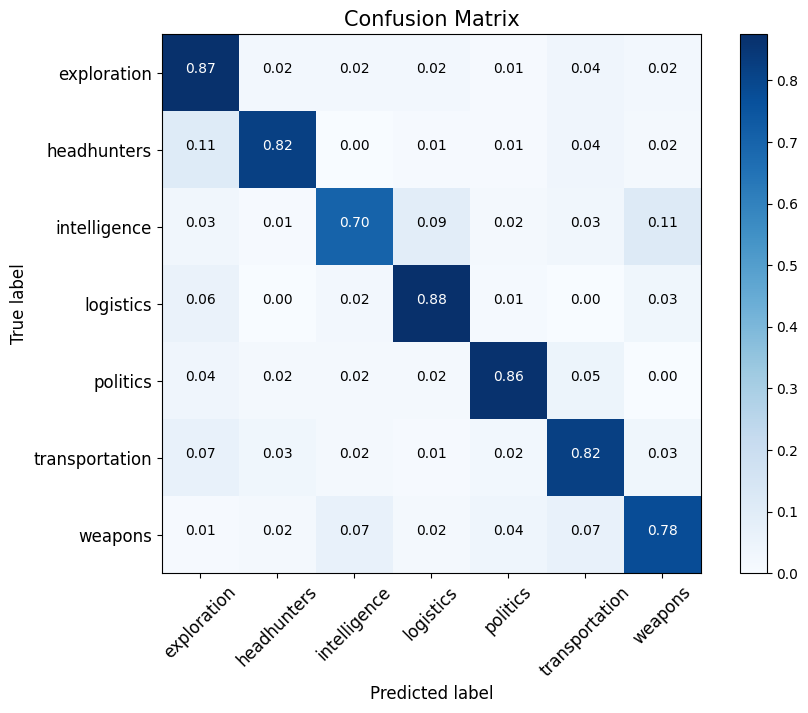

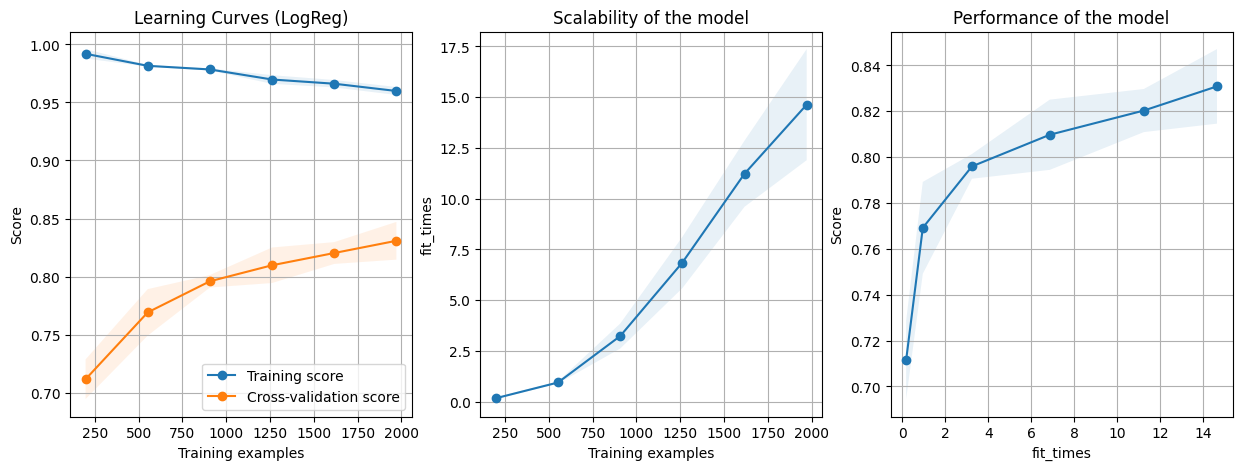

In [37]:
y_test_pred_spacy = best_model_spacy.predict(X_test_spacy)
evaluate_model_new(X_train_spacy, y_train_clean, y_test_clean, y_test_pred_spacy, best_model_spacy)

In [ ]:
# encoder = LabelEncoder()
# y_encoded = encoder.fit_transform(y)
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state=42)

# # sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # Optimized version
# sbert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')  # For handling multilingual nouns

# # Generate embeddings
# X_train_embeddings = sbert_model.encode(X_train.tolist(), batch_size=16, show_progress_bar=True)
# X_test_embeddings = sbert_model.encode(X_test.tolist(), batch_size=16, show_progress_bar=True)

#### Conclusions:

Spacy embeddings uses static word embedding so it doesn't take into account the relationships between words, so they are not so strong when identifying the context of the sentences. 

Embeddings from Transformer's models based on the context might improve the performance.

#### 7.2) Using Transformers model

Using Logistic Regression for classification

In [44]:
model_transformer = SentenceTransformer('all-MiniLM-L6-v2')

In [21]:
X_train_transformer = get_transformer_embeddings(model_transformer, X_train_clean)
X_val_transformer = get_transformer_embeddings(model_transformer, X_val_clean)
X_test_transformer = get_transformer_embeddings(model_transformer, X_test_clean)

Batches: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


In [22]:
model_grid_transformer = {'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
best_model_transformer, best_params_logreg_transformer = train_logistic_regression(X_train_transformer, y_train_clean, model_grid_transformer)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}


(accuracy, f1) are: (0.901427, 0.900897)

Classification Report:
                 precision    recall  f1-score   support

   exploration       0.90      0.91      0.91       139
   headhunters       0.92      0.95      0.93       110
  intelligence       0.82      0.77      0.79        98
     logistics       0.87      0.90      0.88        88
      politics       0.94      0.94      0.94       111
transportation       0.94      0.94      0.94       121
       weapons       0.89      0.88      0.89       104

      accuracy                           0.90       771
     macro avg       0.90      0.90      0.90       771
  weighted avg       0.90      0.90      0.90       771



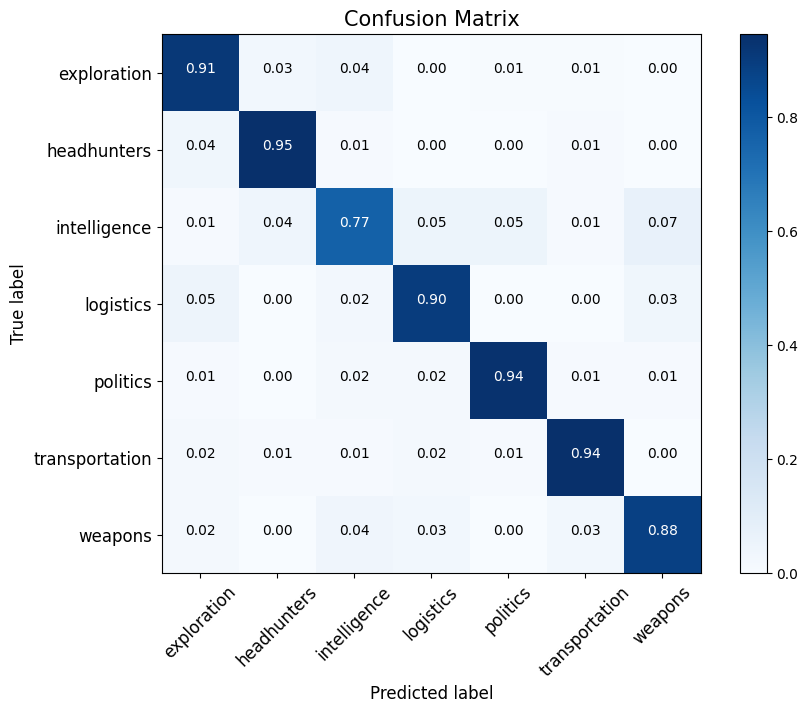

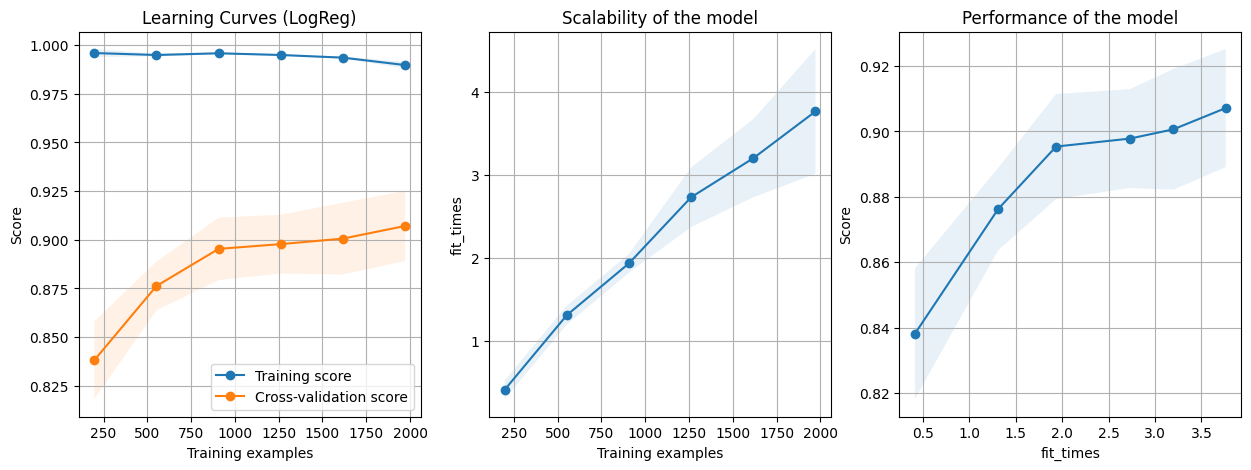

In [23]:
y_test_pred_transformer = best_model_transformer.predict(X_test_transformer)
evaluate_model_new(X_train_transformer, y_train_clean, y_test_clean, y_test_pred_transformer, best_model_transformer)

In [24]:
data_clean.head(2)

,Text,tag,cleaned_text,no_stopwords,lemmatized,stemmed,word_count
file,,,,,,,
59848,Article-I.D.: cs.controversy_733694426\n\n\nCO...,exploration,controversial questions these issues periodica...,controversial questions issues periodically co...,controversial question issue periodically come...,controversi question issu period come much arg...,1114
59849,Article-I.D.: cs.groups_733694492\n\n\nSPACE A...,exploration,space activistinterestresearch groups and spac...,space activistinterestresearch groups space pu...,space activistinterestresearch group space pub...,space activistinterestresearch group space pub...,1312


In [25]:
X_clean_all, X_test_clean_all, y_clean_all, y_test_clean_all = train_test_split(data_clean['cleaned_text'], data_clean['tag'], test_size=0.2, random_state=42)
X_train_clean_all, X_val_clean_all, y_train_clean_all, y_val_clean_all = train_test_split(X_clean_all, y_clean_all, test_size=0.2, random_state=42)

In [26]:
X_train_transformer_all = get_transformer_embeddings(model_transformer, X_train_clean_all)
X_val_transformer_all = get_transformer_embeddings(model_transformer, X_val_clean_all)
X_test_transformer_all = get_transformer_embeddings(model_transformer, X_test_clean_all)

Batches: 100%|██████████| 25/25 [00:30<00:00,  1.20s/it]


In [27]:
model_grid_transformer_all = {'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
best_model_transformer_all, best_params_logreg_transformer_all = train_logistic_regression(X_train_transformer_all, y_train_clean_all, model_grid_transformer_all)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


(accuracy, f1) are: (0.910506, 0.910706)

Classification Report:
                 precision    recall  f1-score   support

   exploration       0.94      0.91      0.93       139
   headhunters       0.91      0.96      0.94       110
  intelligence       0.84      0.82      0.83        98
     logistics       0.80      0.93      0.86        88
      politics       0.95      0.95      0.95       111
transportation       0.96      0.93      0.95       121
       weapons       0.95      0.86      0.90       104

      accuracy                           0.91       771
     macro avg       0.91      0.91      0.91       771
  weighted avg       0.91      0.91      0.91       771



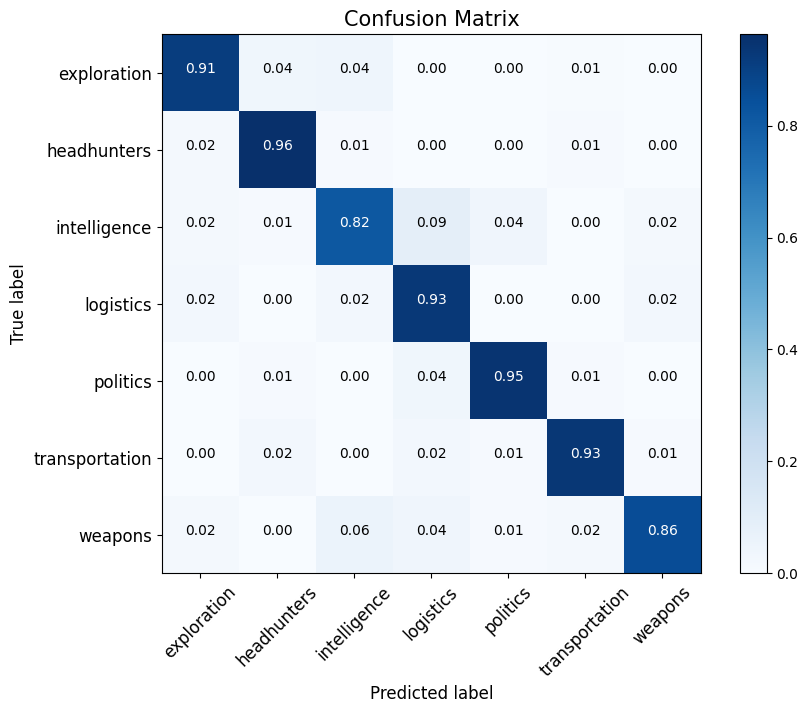

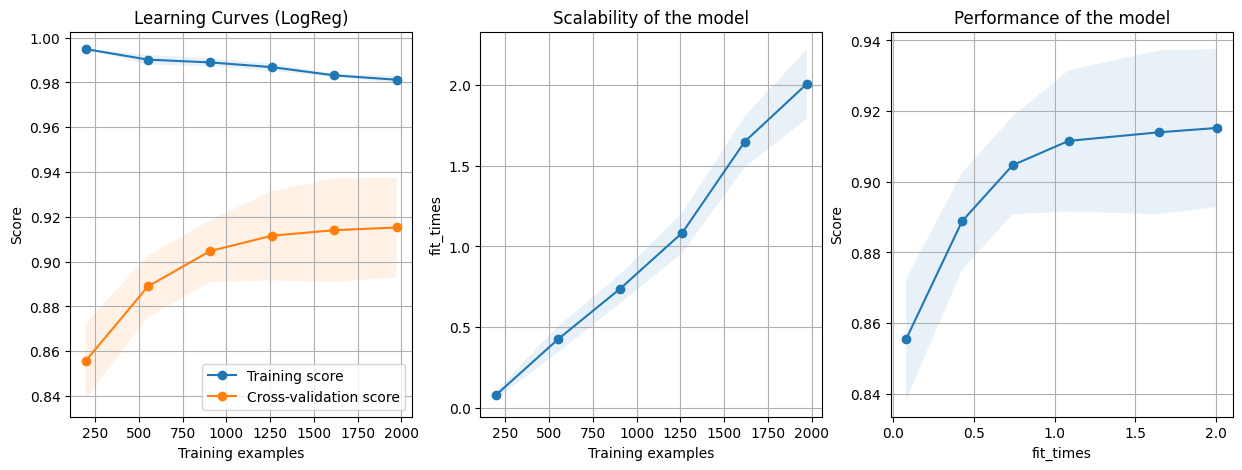

In [28]:
y_test_pred_transformer_all = best_model_transformer_all.predict(X_test_transformer_all)
evaluate_model_new(X_train_transformer_all, y_train_clean_all, y_test_clean_all, y_test_pred_transformer_all, best_model_transformer_all)

#### Conclusions:

The dataset is full of technical and domain-specific text with a lot of detail and nois. The LLM may struggle to give importance to important terms that are critical for classification.

Having so long texts might provoque the important phrases to be covered by less relevant content. 

all-MiniLM-L6-v2 has been trained for general text data, some specific vocabulary might not be inside its pretraining corpus.

Training with clean data without eliminating stopwords and lemmatize improves slightlz the performance as the model is capable of reallz understanding the meaning of the sentences.

#### 7.3) Using Transformers model

Using Random Forest for classification

In [34]:
param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
best_model_rf, best_params_rf = train_random_forest(X_train_transformer, y_train_clean, param_grid_rf)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}
best_model_rf, best_params_rf = train_random_forest(X_train_transformer, y_train_clean, param_grid_rf)

(accuracy, f1) are: (0.888457, 0.887351)

Classification Report:
                 precision    recall  f1-score   support

   exploration       0.87      0.92      0.90       139
   headhunters       0.90      0.92      0.91       110
  intelligence       0.88      0.70      0.78        98
     logistics       0.80      0.92      0.86        88
      politics       0.95      0.95      0.95       111
transportation       0.92      0.90      0.91       121
       weapons       0.88      0.88      0.88       104

      accuracy                           0.89       771
     macro avg       0.89      0.88      0.88       771
  weighted avg       0.89      0.89      0.89       771



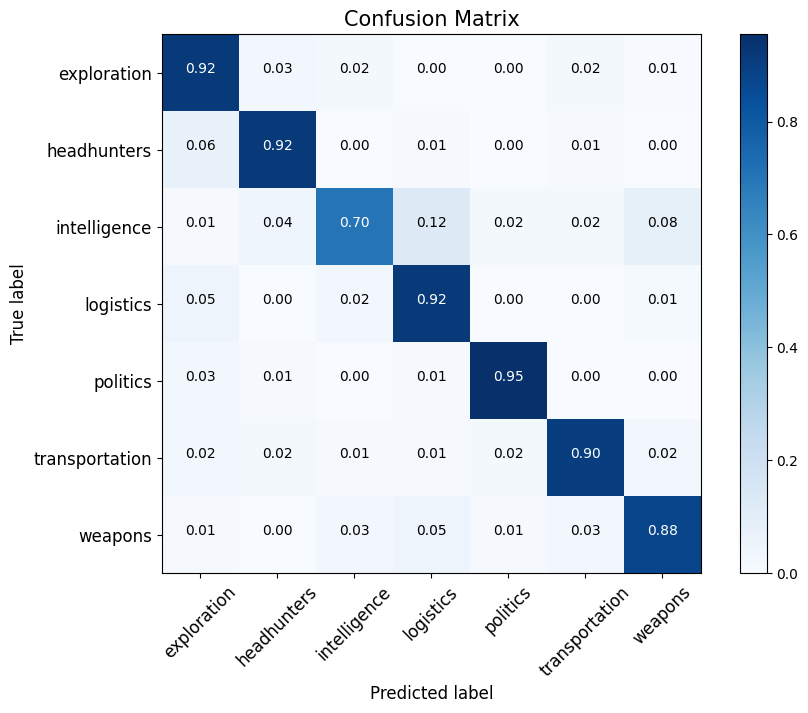

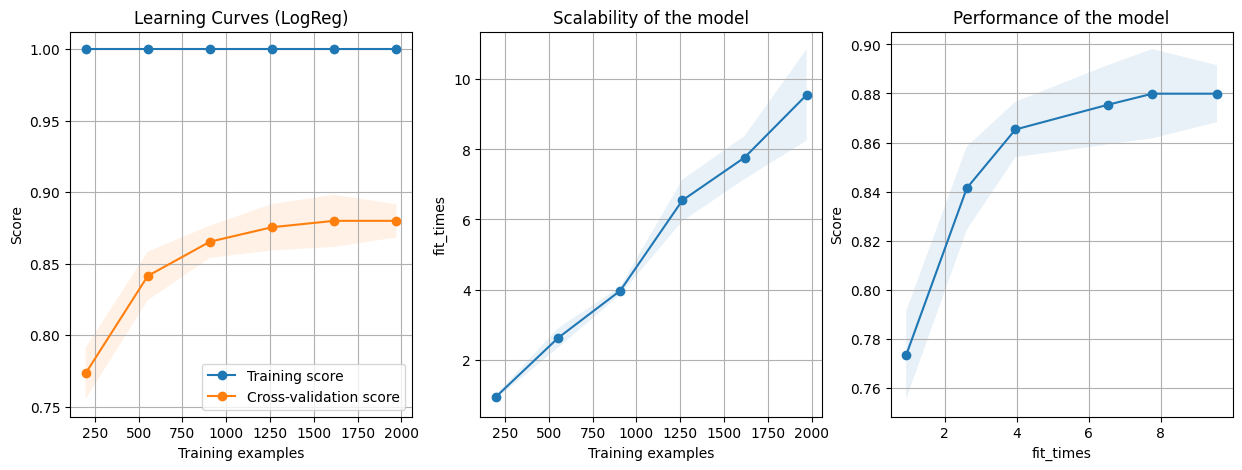

In [35]:
y_test_pred_rf = best_model_rf.predict(X_test_transformer)
evaluate_model_new(X_train_transformer, y_train_clean, y_test_clean, y_test_pred_rf, best_model_rf)

#### 7.4) Fine tuning LLM

API key and pay some money for using this service

## 

### 8) PART 2. NEW CATEGORY

In [18]:
path_new = '../part2/dataset'
tags_new = os.listdir(path_new)
tags_new

['elite']

In [19]:
data_new = get_all_dfs(path_new, tags_new)
print(data_new.shape)
data_new.tail()

(10, 2)


,Text,tag
file,,
214799,oscar snubs: critics' favourite myth – until ...,elite
231166,the olsen twins mary kate and ashley spill the...,elite
237803,good morning britain host kate garraway in tal...,elite
36076,James Jordan’s takes ANOTHER pop at Celebrity ...,elite
66785,kate middletons new private secretary catherin...,elite


In [20]:
data_new[['cleaned_text', 'no_stopwords', 'lemmatized', 'stemmed']] = data_new['Text'].apply(lambda x: pd.Series(clean_text(x)))
data_new['word_count'] = data_new['lemmatized'].apply(lambda x: len(x.split()))

In [21]:
data_new['word_count'].describe()

count     10.000000
mean     172.800000
std      128.861511
min       26.000000
25%       80.500000
50%      167.000000
75%      199.000000
max      481.000000
Name: word_count, dtype: float64

In [22]:
data_new.shape

(10, 7)

In [23]:
data_new.columns

Index(['Text', 'tag', 'cleaned_text', 'no_stopwords', 'lemmatized', 'stemmed',
       'word_count'],
      dtype='object')

In [24]:
data_clean.columns

Index(['Text', 'tag', 'cleaned_text', 'no_stopwords', 'lemmatized', 'stemmed',
       'word_count'],
      dtype='object')

In [25]:
data_new_final=pd.concat([data_new, data_clean])

In [26]:
data_new_final.head()

,Text,tag,cleaned_text,no_stopwords,lemmatized,stemmed,word_count
file,,,,,,,
110050,antonia sourcenelle kisses a lot at funk ball\...,elite,antonia sourcenelle kisses a lot at funk ball ...,antonia sourcenelle kisses lot funk ball actre...,antonia sourcenelle kiss lot funk ball actress...,antonia sourcenel kiss lot funk ball actress p...,69
171984,the weekend of the famous in pictures. the wee...,elite,the weekend of the famous in pictures the week...,weekend famous pictures weekend celebrities pi...,weekend famous picture weekend celebrity pictu...,weekend famou pictur weekend celebr pictur úrs...,26
178320,andy murray and kim sears name baby sophia oli...,elite,andy murray and kim sears name baby sophia oli...,andy murray kim sears name baby sophia olivia ...,andy murray kim sears name baby sophia olivia ...,andi murray kim sear name babi sophia olivia m...,200
182367,sheldon cooper is again highest paid televisio...,elite,sheldon cooper is again highest paid televisio...,sheldon cooper highest paid television actor j...,sheldon cooper highest paid television actor j...,sheldon cooper highest paid televis actor jim ...,109
182542,5 celebrities who became fathers again at a la...,elite,5 celebrities who became fathers again at a la...,5 celebrities became fathers late age mick jag...,5 celebrity became father late age mick jagger...,5 celebr becam father late age mick jagger ron...,71


Calculate the performance with the data cleaned without balancing the data. Let's see how bad the performance is for that class

Batches: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
(accuracy, f1) are: (0.919793, 0.919056)

Classification Report:
                 precision    recall  f1-score   support

         elite       0.00      0.00      0.00         1
   exploration       0.95      0.91      0.93       139
   headhunters       0.91      0.97      0.94       110
  intelligence       0.84      0.85      0.85        89
     logistics       0.89      0.90      0.90        90
      politics       0.97      0.98      0.97       122
transportation       0.96      0.96      0.96       115
       weapons       0.88      0.86      0.87       107

      accuracy                           0.92       773
     macro avg       0.80      0.80      0.80       773
  weighted avg       0.92      0.92      0.92       773



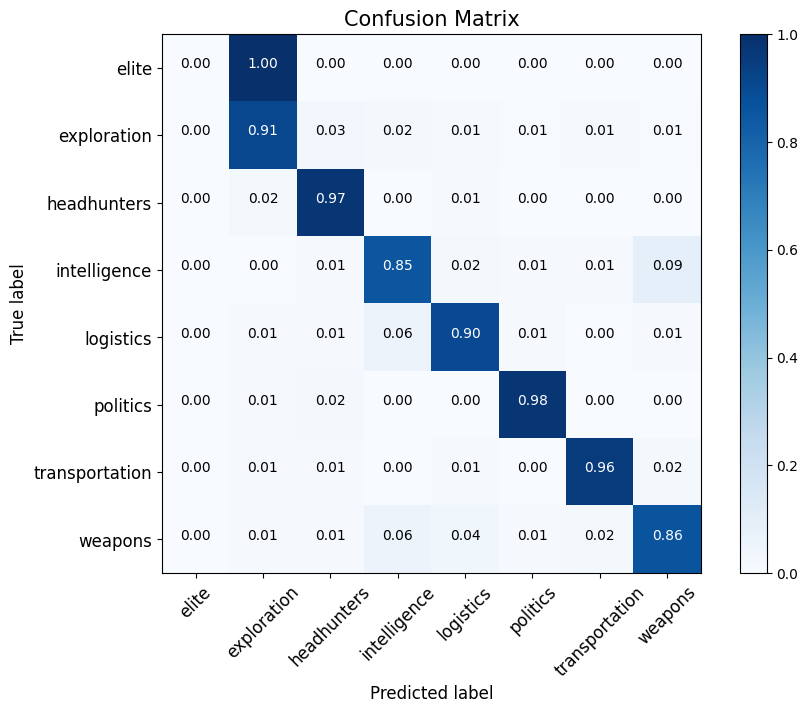

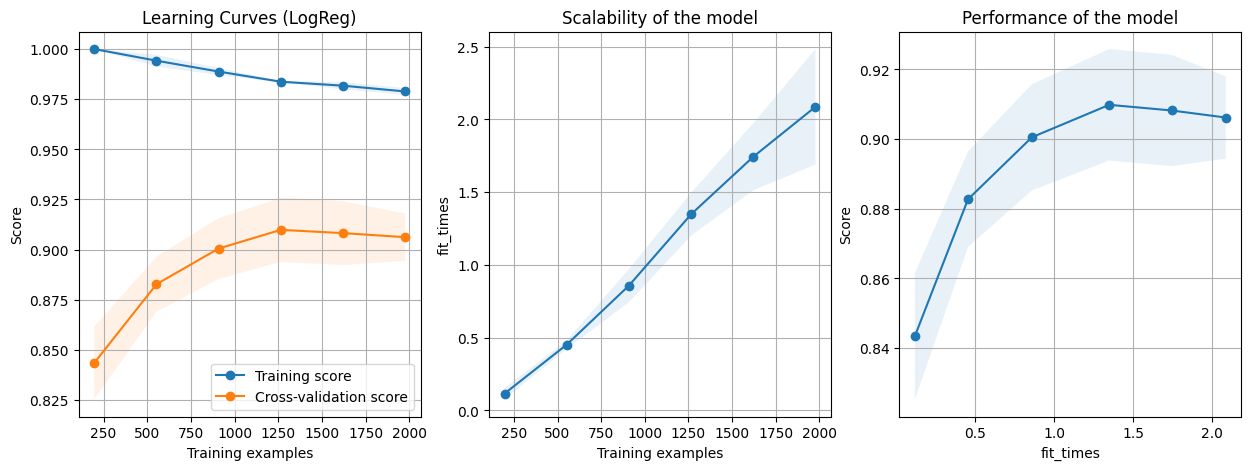

In [ ]:
# Splitting the dataset into training, validation, and test sets
X_new, X_new_test, y_new, y_new_test = train_test_split(data_new_final['cleaned_text'], data_new_final['tag'], test_size=0.4, random_state=42)
X_new_train, X_new_val, y_new_train, y_new_val = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

X_new_train_transformer = get_transformer_embeddings(model_transformer, X_new_train)
X_new_val_transformer = get_transformer_embeddings(model_transformer, X_new_val)
X_new_test_transformer = get_transformer_embeddings(model_transformer, X_new_test)

model_grid_transformer_new = {'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
best_model_transformer_new, best_params_logreg_transformer_new = train_logistic_regression(X_new_train_transformer, y_new_train, model_grid_transformer_new)

y_new_test_pred_transformer = best_model_transformer_new.predict(X_new_test_transformer)
evaluate_model_new(X_new_train_transformer, y_new_train, y_new_test, y_new_test_pred_transformer, best_model_transformer_new)

In [40]:
data_new_final

,Text,tag,cleaned_text,no_stopwords,lemmatized,stemmed,word_count
file,,,,,,,
110050,antonia sourcenelle kisses a lot at funk ball\...,elite,antonia sourcenelle kisses a lot at funk ball ...,antonia sourcenelle kisses lot funk ball actre...,antonia sourcenelle kiss lot funk ball actress...,antonia sourcenel kiss lot funk ball actress p...,69
171984,the weekend of the famous in pictures. the wee...,elite,the weekend of the famous in pictures the week...,weekend famous pictures weekend celebrities pi...,weekend famous picture weekend celebrity pictu...,weekend famou pictur weekend celebr pictur úrs...,26
178320,andy murray and kim sears name baby sophia oli...,elite,andy murray and kim sears name baby sophia oli...,andy murray kim sears name baby sophia olivia ...,andy murray kim sears name baby sophia olivia ...,andi murray kim sear name babi sophia olivia m...,200
182367,sheldon cooper is again highest paid televisio...,elite,sheldon cooper is again highest paid televisio...,sheldon cooper highest paid television actor j...,sheldon cooper highest paid television actor j...,sheldon cooper highest paid televis actor jim ...,109
182542,5 celebrities who became fathers again at a la...,elite,5 celebrities who became fathers again at a la...,5 celebrities became fathers late age mick jag...,5 celebrity became father late age mick jagger...,5 celebr becam father late age mick jagger ron...,71
...,...,...,...,...,...,...,...
55246,\nAs quoted from <1993Apr17.025258.7013@micros...,weapons,as quoted from 1993apr170252587013microsoftcom...,quoted 1993apr170252587013microsoftcom anthony...,quoted 1993apr170252587013microsoftcom anthony...,quot 1993apr170252587013microsoftcom anthonyfm...,87
55247,\nIn article <2071@rwing.UUCP> pat@rwing.UUCP ...,weapons,in article 2071rwinguucp patrwinguucp pat myrt...,article 2071rwinguucp patrwinguucp pat myrto w...,article 2071rwinguucp patrwinguucp pat myrto w...,articl 2071rwinguucp patrwinguucp pat myrto wr...,73
55473,07:24:55 GMT\n <1qjmnuINNlmd@cl...,weapons,072455 gmt 1qjmnuinnlmdclemhandheldcom cmm0902...,072455 gmt 1qjmnuinnlmdclemhandheldcom cmm0902...,072455 gmt 1qjmnuinnlmdclemhandheldcom cmm0902...,072455 gmt 1qjmnuinnlmdclemhandheldcom cmm0902...,256


In [60]:
X_new_lem, X_new_test_lem, y_new_lem, y_new_test_lem = train_test_split(data_new_final['lemmatized'], data_new_final['tag'], test_size=0.2, random_state=42)
X_new_train_lem, X_new_val_lem, y_new_train_lem, y_new_val_lem = train_test_split(X_new_lem, y_new_lem, test_size=0.2, random_state=42)

Best TF-IDF params: {'max_df': 0.5, 'max_features': 20000, 'min_df': 5, 'ngram_range': (1, 2)}
Best F1-Score: 0.9433526788379848
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
(accuracy, f1) are: (0.932730, 0.932379)

Classification Report:
                 precision    recall  f1-score   support

         elite       0.00      0.00      0.00         1
   exploration       0.95      0.95      0.95       139
   headhunters       0.85      0.97      0.91       110
  intelligence       0.93      0.90      0.91        89
     logistics       0.92      0.94      0.93        90
      politics       0.98      0.94      0.96       122
transportation       0.93      0.94      0.94       115
       weapons       0.97      0.88      0.92       107

      accuracy                           0.93       773
     macro avg       0.82      0.82      0.82       773
  weighted avg       0.93      0.93      0.

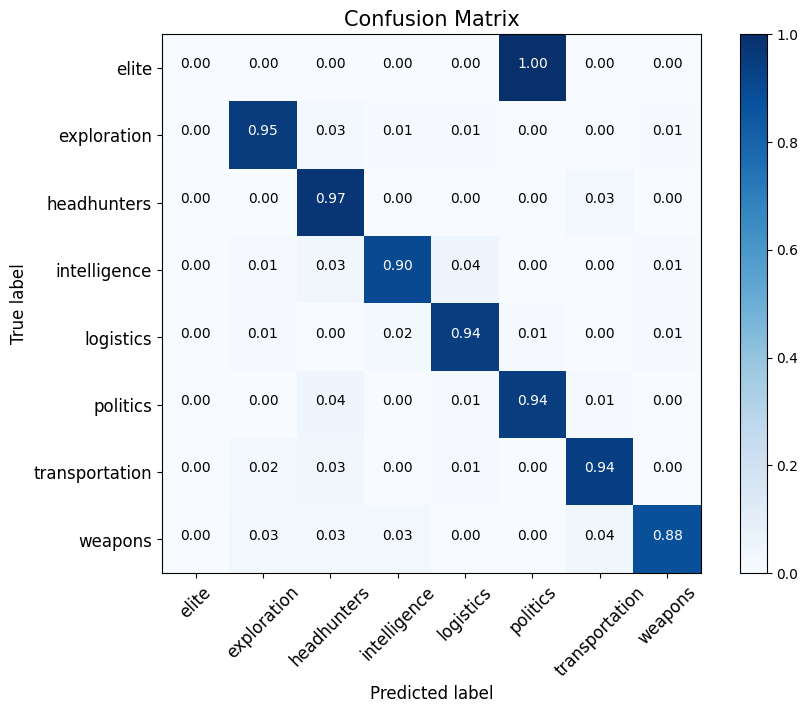

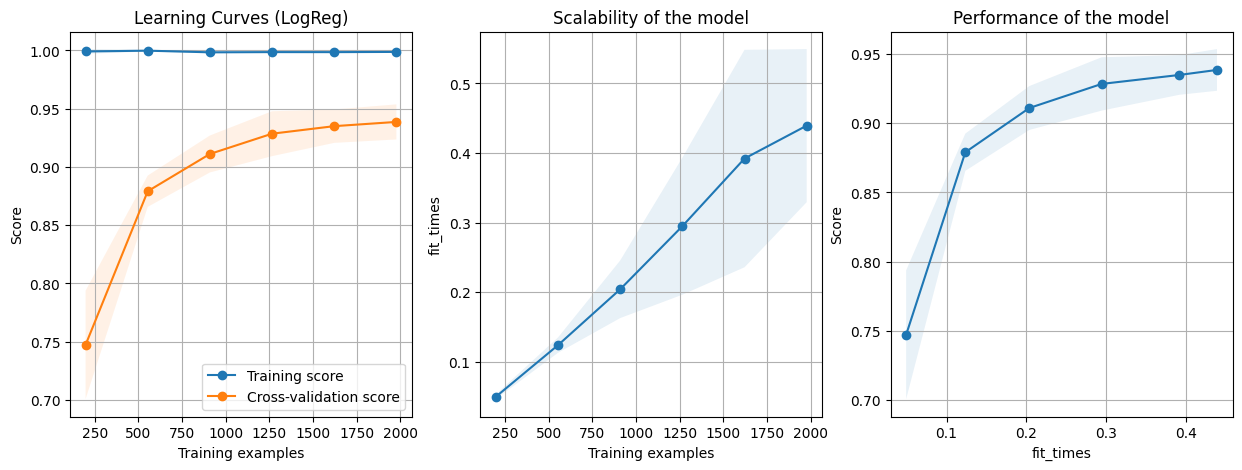

In [59]:
# Define the parameter grid
tfidf_grid={'max_features': [5000, 10000, 20000], 'min_df': [5, 10, 20], 'max_df': [0.5, 0.7, 1.0], 'ngram_range': [(1, 1), (1, 2)]}
best_vectorizer_new, X_train_tfidf_new, X_val_tfidf_new, best_params_new = tfidf_params(X_new_train_lem, X_new_val_lem, y_new_train_lem, y_new_val_lem, tfidf_grid)

model_grid = {'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
best_model_new, best_params_logreg_new = train_logistic_regression(X_train_tfidf_new, y_new_train_lem, model_grid)

X_test_tfidf_new = best_vectorizer_new.transform(X_new_test_lem)
y_test_pred_new = best_model_new.predict(X_test_tfidf_new)
evaluate_model_new(X_train_tfidf_new, y_new_train_lem, y_new_test_lem, y_test_pred_new, best_model_new)

#### 8.1) Synthetic Data Generation

There are very rows in our datasets, first approach would be creating new records using SMOTE

In [62]:
print("Original class distribution:", Counter(y_new_train_lem))

Original class distribution: Counter({'transportation': 397, 'politics': 391, 'headhunters': 385, 'exploration': 374, 'weapons': 334, 'logistics': 315, 'intelligence': 269, 'elite': 7})


In [63]:
print("Original class distribution:", Counter(y_new_val_lem))

Original class distribution: Counter({'weapons': 105, 'politics': 96, 'intelligence': 95, 'headhunters': 93, 'transportation': 84, 'exploration': 74, 'logistics': 69, 'elite': 2})


In [64]:
print("Original class distribution:", Counter(y_new_test_lem))

Original class distribution: Counter({'exploration': 139, 'politics': 122, 'transportation': 115, 'headhunters': 110, 'weapons': 107, 'logistics': 90, 'intelligence': 89, 'elite': 1})


In [40]:
elite_data['lemmatized']

file
110050    antonia sourcenelle kiss lot funk ball actress...
171984    weekend famous picture weekend celebrity pictu...
178320    andy murray kim sears name baby sophia olivia ...
182367    sheldon cooper highest paid television actor j...
182542    5 celebrity became father late age mick jagger...
214799    oscar snub critic favourite myth academy pick ...
231166    olsen twin mary kate ashley spill bean full ho...
237803    good morning britain host kate garraway talk h...
36076     james jordan take another pop celebrity big br...
66785     kate middleton new private secretary catherine...
Name: lemmatized, dtype: object

In [42]:
output_file = 'output.txt'
elite_data['lemmatized'].to_csv(output_file, index=False, header=False)

print(f"Column '{elite_data['lemmatized']}' has been written to {output_file}.")

Column 'file
110050    antonia sourcenelle kiss lot funk ball actress...
171984    weekend famous picture weekend celebrity pictu...
178320    andy murray kim sears name baby sophia olivia ...
182367    sheldon cooper highest paid television actor j...
182542    5 celebrity became father late age mick jagger...
214799    oscar snub critic favourite myth academy pick ...
231166    olsen twin mary kate ashley spill bean full ho...
237803    good morning britain host kate garraway talk h...
36076     james jordan take another pop celebrity big br...
66785     kate middleton new private secretary catherine...
Name: lemmatized, dtype: object' has been written to output.txt.


In [27]:
# Separate elite class
elite_data = data_new_final[data_new_final['tag'] == 'elite']
non_elite_data = data_new_final[data_new_final['tag'] != 'elite']

In [28]:
# Split non-elite data
X_non_elite, X_non_elite_test, y_non_elite, y_non_elite_test = train_test_split(non_elite_data['lemmatized'], non_elite_data['tag'], test_size=0.2, random_state=42)
X_non_elite_train, X_non_elite_val, y_non_elite_train, y_non_elite_val = train_test_split(X_non_elite, y_non_elite, test_size=0.2, random_state=42)

In [29]:
# Add elite data to splits
X_train_combined = pd.concat([X_non_elite_train, elite_data['lemmatized']])
y_train_combined = pd.concat([y_non_elite_train, elite_data['tag']])

X_val_combined = X_non_elite_val  # Elite is already fully included in train
y_val_combined = y_non_elite_val

X_test_combined = pd.concat([X_non_elite_test, elite_data['lemmatized']])
y_test_combined = pd.concat([y_non_elite_test, elite_data['tag']])

In [30]:
tfidf_grid={'max_features': [5000, 10000, 20000], 'min_df': [5, 10, 20], 'max_df': [0.5, 0.7, 1.0], 'ngram_range': [(1, 1), (1, 2)]}
best_vectorizer_smote, X_train_tfidf_smote, X_val_tfidf_smote, best_params_smote = tfidf_params(X_train_combined, X_val_combined, y_train_combined, y_val_combined, tfidf_grid)

Best TF-IDF params: {'max_df': 0.7, 'max_features': 10000, 'min_df': 5, 'ngram_range': (1, 2)}
Best F1-Score: 0.944421133484216


In [31]:
X_train_dense = X_train_tfidf_smote.toarray()
smote = SMOTE(sampling_strategy={'elite': 50}, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_dense, y_train_combined)

In [32]:
print("Resampled class distribution:", Counter(y_train_resampled))

Resampled class distribution: Counter({'transportation': 396, 'politics': 393, 'headhunters': 380, 'exploration': 359, 'weapons': 354, 'logistics': 302, 'intelligence': 281, 'elite': 50})


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Logistic Regression Params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
(accuracy, f1) are: (0.938540, 0.938524)

Classification Report:
                 precision    recall  f1-score   support

         elite       1.00      1.00      1.00        10
   exploration       0.96      0.94      0.95       139
   headhunters       0.86      0.97      0.91       110
  intelligence       0.98      0.85      0.91        98
     logistics       0.92      0.95      0.94        88
      politics       0.93      0.96      0.95       111
transportation       0.96      0.95      0.95       121
       weapons       0.96      0.93      0.95       104

      accuracy                           0.94       781
     macro avg       0.95      0.94      0.94       781
  weighted avg       0.94      0.94      0.94       781



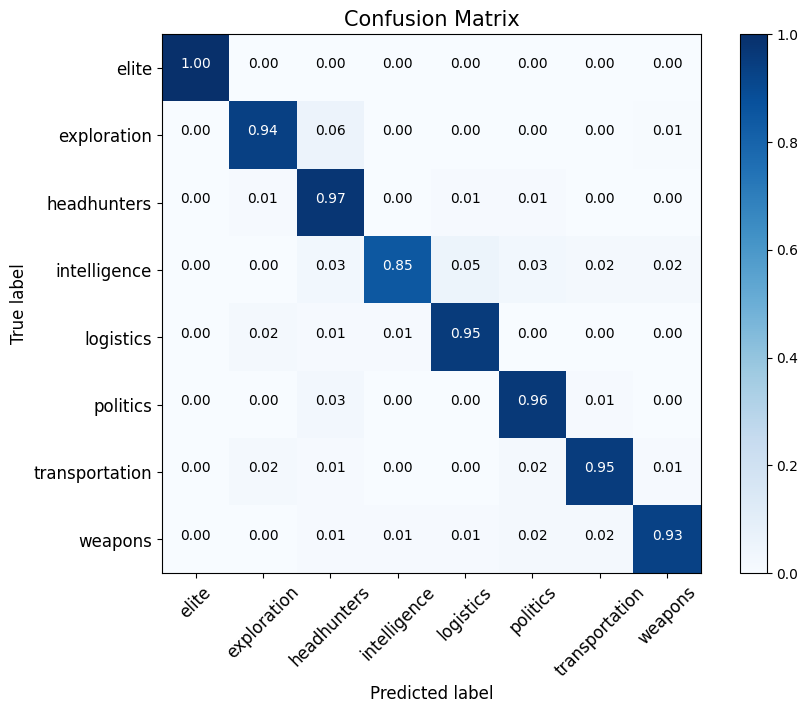

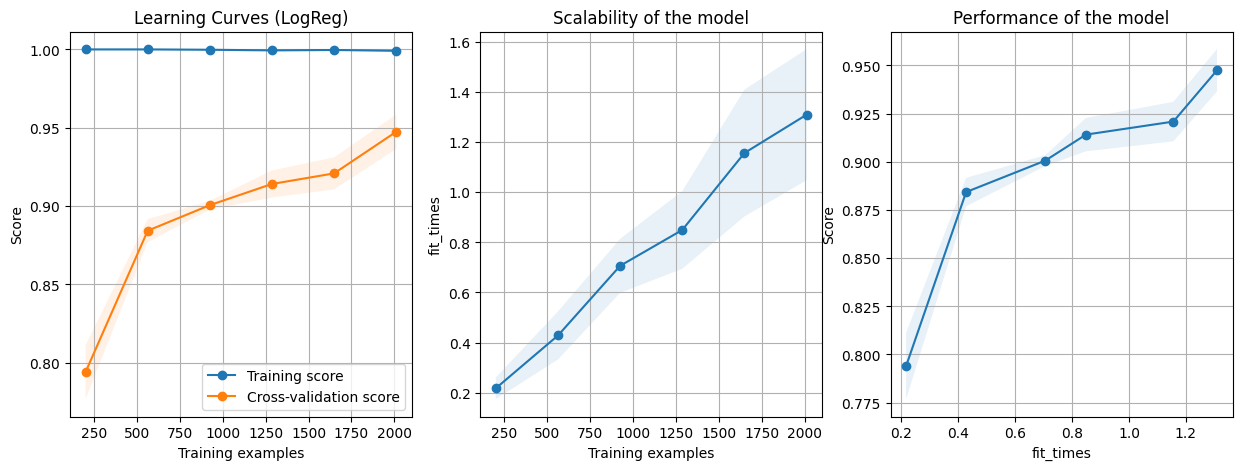

In [34]:
model_grid_sampled = {
    'solver': ['liblinear'],  # Use a single solver
    'C': [1, 10],            # Narrow down the regularization strength
    'penalty': ['l2'],       # Focus on 'l2' regularization
    'class_weight': ['balanced']}  # Use balanced weights for imbalanced databest_model_smote, best_params_logreg_smote = train_logistic_regression(X_train_resampled, y_train_resampled, model_grid_sampled)

best_model_smote, best_params_logreg_smote = train_logistic_regression(X_train_resampled, y_train_resampled, model_grid_sampled)
X_test_smote=best_vectorizer_smote.transform(X_test_combined)
y_test_pred_smote = best_model_smote.predict(X_test_smote)
evaluate_model_new(X_train_resampled, y_train_resampled, y_test_combined, y_test_pred_smote, best_model_smote)

In [ ]:
# model_grid_sampled={'solver': ['liblinear', 'saga'], 'C': [0.01, 1, 10], 'penalty': ['l2'],'class_weight': [None, 'balanced']}  # Add class weighting options
# best_model_smote, best_params_logreg_smote = train_logistic_regression(X_train_resampled, y_train_resampled, model_grid_sampled)

# X_test_smote=best_vectorizer_smote.transform(X_test_combined)
# y_test_pred_smote = best_model_smote.predict(X_test_smote)
# evaluate_model_new(X_train_resampled, y_train_resampled, y_test_combined, y_test_pred_smote, best_model_smote)

In [90]:
synthetic_indices

range(2475, 2515)

In [92]:
X_train_resampled[synthetic_indices]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7258 stored elements and shape (40, 10000)>

In [36]:
synthetic_indices = range(len(y_train_combined), len(y_train_resampled))
synthetic_samples = X_train_resampled[synthetic_indices]

# Decode synthetic samples back to text using TF-IDF vectorizer
synthetic_texts = []
feature_names = best_vectorizer_smote.get_feature_names_out()

for sample in synthetic_samples[:5]:  # Limit to first 5 samples
    non_zero_indices = np.nonzero(sample)[0]  # Get non-zero indices
    words = [feature_names[i] for i in non_zero_indices]  # Map indices to feature names
    synthetic_texts.append(" ".join(words))

# Display synthetic samples
print("\nSynthetic Samples:")
for i, text in enumerate(synthetic_texts):
    print(f"Synthetic Sample {i + 1}:")
    print(text)


Synthetic Samples:
Synthetic Sample 1:
20 20 year 28 29 51 73 added admitted age already also always anchor ant appeal appear approached asked aspect australia australian became ben britain celebrity challenge character chemistry child chosen coming comment common continue could currently deal decade decided declined doctor doesnt doesnt seem doubt entering example experience fact family father fifty flag flying focus footage four front game get girlfriend gold good great head heading hit hmm host im including interview jamie job joined jones keep know know would lady landed last last night last year late later life long love made making married martin massive matter men minute morgan morning movie much name news night november old part past pregnant prepare problem rating reached reality recovery region return revealed robert said second see seem set shape shell shes show sign signed since source speculation spending spin spokesperson stage stand star start suggested sun talk test th

In [38]:
# Compare synthetic samples with original data
original_embeddings = X_train_dense
synthetic_embeddings = np.array(synthetic_samples)

similarities = cosine_similarity(synthetic_embeddings, original_embeddings)
print("\nAverage Cosine Similarity between synthetic and original samples:", np.mean(similarities))


Average Cosine Similarity between synthetic and original samples: 0.02177453720273788


### With Embeddings

In [ ]:
# Splitting the dataset into training, validation, and test sets
X_new, X_new_test, y_new, y_new_test = train_test_split(data_new_final['cleaned_text'], data_new_final['tag'], test_size=0.4, random_state=42)
X_new_train, X_new_val, y_new_train, y_new_val = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

X_new_train_transformer = get_transformer_embeddings(model_transformer, X_new_train)
X_new_val_transformer = get_transformer_embeddings(model_transformer, X_new_val)
X_new_test_transformer = get_transformer_embeddings(model_transformer, X_new_test)

model_grid_transformer_new = {'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
best_model_transformer_new, best_params_logreg_transformer_new = train_logistic_regression(X_new_train_transformer, y_new_train, model_grid_transformer_new)

y_new_test_pred_transformer = best_model_transformer_new.predict(X_new_test_transformer)
evaluate_model_new(X_new_train_transformer, y_new_train, y_new_test, y_new_test_pred_transformer, best_model_transformer_new)

In [ ]:
X_train_transformer_smote = get_transformer_embeddings(model_transformer, X_new_train)
X_val_transformer_smote = get_transformer_embeddings(model_transformer, X_new_val)
X_test_transformer_smote = get_transformer_embeddings(model_transformer, X_new_test)

#### 8.1) Data Augmentation

In [ ]:
from nltk.corpus import wordnet
import random

def synonym_replacement(text, n=2):
    """
    Replace n words in the text with their synonyms.

    Parameters:
        text (str): Input text.
        n (int): Number of words to replace with synonyms.

    Returns:
        str: Augmented text with synonyms.
    """
    words = text.split()
    new_text = words[:]
    for _ in range(n):
        word_idx = random.randint(0, len(words) - 1)
        synonyms = wordnet.synsets(words[word_idx])
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_text[word_idx] = synonym if synonym != words[word_idx] else new_text[word_idx]
    return ' '.join(new_text)


### 8.2) Paraphrase text

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

def paraphrase_text(text, model_name="t5-small", max_length=512, num_return_sequences=3):
    """
    Paraphrase a given text using a T5 model.

    Parameters:
        text (str): Input text.
        model_name (str): Pre-trained T5 model to use.
        max_length (int): Maximum length of the generated text.
        num_return_sequences (int): Number of paraphrased texts to generate.

    Returns:
        list: List of paraphrased texts.
    """
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    tokenizer = T5Tokenizer.from_pretrained(model_name)

    input_text = f"paraphrase: {text} </s>"
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True)
    outputs = model.generate(
        input_ids, max_length=max_length, num_return_sequences=num_return_sequences, num_beams=5, early_stopping=True
    )
    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]


### 3) SMOTE for creating synthetic data